<a href="https://colab.research.google.com/github/dellaanima/NLP_GoingDeeper/blob/main/08/Project_Translator_Seq2Seq%2BAttention_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean - English Translation Model



**Table of Contents**

## Rubric

# Import Modules

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and direc

In [1]:
!pip install python-mecab-ko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 37.5 MB/s eta 0:00:00


In [2]:
import re
import os
import io
import random   #학습 데이터 섞기
import tarfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
#from konlpy.tag import Mecab -> this doesn't work
from mecab import MeCab

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

In [3]:
plt.rcParams['font.family'] = 'NanumBarunGothic'  # 나눔바른고딕 폰트 사용

## About the Dataset

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [4]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz


--2023-08-25 02:18:53--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2023-08-25 02:18:53--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean

In [20]:
path_to_ko = "/content/korean-english-park.train.ko"
path_to_en = "/content/korean-english-park.train.en"

with open(path_to_ko, "r") as f:
    kor_raw = f.read().splitlines()

with open(path_to_en, "r") as f:
    eng_raw = f.read().splitlines()

dataset = pd.DataFrame(zip(kor_raw, eng_raw), columns=["kor", "eng"])

In [21]:
dataset.sample(50)

,kor,eng
24915,반면 세비야가 프라하전에서 무승부를 기록하고 아스날이 홈에서 스테아우아 부크레슈티를...,"However, a draw and a win for Arsenal at home ..."
64352,"‘플라잉 캥거루’로 알려진 콴타스와 브리티시 항공은 이미 아메리칸 항공, 캐세이 퍼...",and BA are partners in the Oneworld Global All...
49319,이 보고서는 또 일부 내륙 강의 증발률은 15% 증가할 것이라고 밝혔다.,It also said evaporation rates for some inland...
40187,그는 이후 국가 기밀정보 누설 혐의로 유죄를 선고받았다.,He was convicted of leaking state secrets.
47269,30분쯤 뒤 토네이도가 학교의 지붕을 부쉈고 그중 일부가 학생들 위로 떨어졌다고 관...,"About a half hour later, a tornado damaged the..."
41510,28일(현지시간) 바그다드 중심 상업지구에서 자동차 폭탄테러가 발생해 시민 21명이...,A car bomb detonated Monday afternoon in a bus...
68101,특정 병에 대한 몸의 면역력을 강화하는 항체를 생산하는 항원을 투입하는 처방인 백신...,"is thought to be 17th century India, when powd..."
29227,이 설문조사를 위탁했던 샤론 그랜트 공중보건위원회(Commission for Pat...,"Sharon Grant, chair of the Commission for Pati..."
33459,마텔사는 이달 장난감에서 아이들이 삼켰을 경우 유해한 작은 납이 발견돼 180만개 ...,The world's largest toymaker recalled more tha...
40112,스톡홀름의 병원에서 검사를 받은 보리는 담당의사로부터 6주 동안 오른쪽 다리에 체중...,"Borg, who received medical treatment at a Stoc..."


데이터에 노이즈가 너무 많다..

<br>

### Dataset 확인 + 중복 데이터 제거

In [22]:
dataset.info()

dup = dataset.duplicated()
dup_count = dup.sum()

print(f"Duplicated Data Num: {dup_count:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   kor     94123 non-null  object
 1   eng     94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
Duplicated Data Num: 15,155


In [23]:
# 중복된 데이터 삭제
dataset = dataset.drop_duplicates()

# 중복 제거 후 데이터프레임 정보 출력
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78968 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   kor     78968 non-null  object
 1   eng     78968 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


### Dataset 각 문장의 단어 수 분석 및 필터링 기준 확인

#### Dataset 문장의 단어 수 시각화 함수

**이상치 판별 방식:**
   - IQR은 데이터의 75% 백분위수(Q3)와 25% 백분위수(Q1)의 차이. IQR = Q3 - Q1.
   - 이상치는 Q1 - 1.5 * IQR 보다 작거나, Q3 + 1.5 * IQR 보다 큰 값으로 정의. ( + 이상치를 판단할 때, 전체 데이터의 분포에 영향을 받는 것이 아니라 Q1과 Q3 사이의 범위에 초점을 맞추게 됨)
  - 수염 (whiskers): 박스의 각 모서리 (Q1, Q3)로 부터 IQR의 1.5배 내에 있는 가장 멀리 떨어진 데이터 점까지 이어져 있는 것이 수염이다.
  - 이상치(Outlier): 수염(whiskers)보다 바깥쪽에 데이터가 존재한다면, 이것은 이상치로 분류 된다.

   -(MAX/100분위)시작 점, 즉 윗 whisker 위치


In [25]:
#데이터 길이 시각화 함수
def show_sentence_words(words_num_list, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)

    # 해당 단어 수에 해당되는 문장이 몇개인지 histogram 으로 확인
    plt.subplot(1, 2, 1)
    plt.hist(words_num_list, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.ylabel('Number of ')
    plt.xlabel('Number of Words in a Sentence')

    # 이상치 처리 위해서 boxplot 으로 확인
    plt.subplot(1, 2, 2)
    plt.boxplot(words_num_list, labels=['word counts'], showmeans=True)

    plt.show()

    print("[Sentence Info]")
    print(f"길이 최대:    {np.max(words_num_list):4d}")
    print(f"길이 최소:    {np.min(words_num_list):4d}")
    print(f"길이 평균:    {np.mean(words_num_list):7.3f}")
    print(f"길이 표준편차: {np.std(words_num_list):7.3f}", end="\n\n")

    percentile25 = np.percentile(words_num_list, 25)
    percentile50 = np.percentile(words_num_list, 50)
    percentile75 = np.percentile(words_num_list, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5

    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")



#### Dataset 필터링할 기준 단어 수 선정
+ 한국어 데이터의 경우, 단어 수 33 이하만 사용 예정
+ 영어 데이터의 경우 ,단어 수 48 이하만 사용 예정

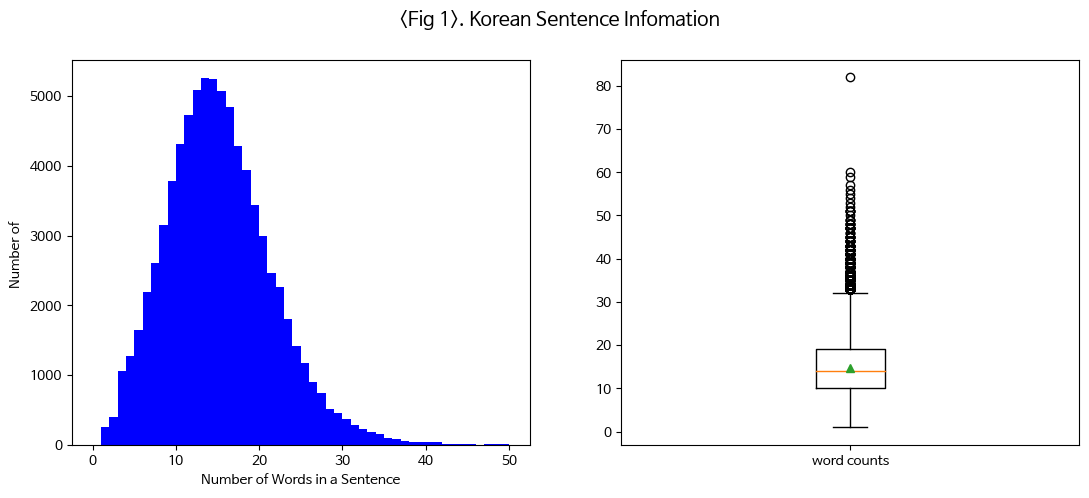

[Sentence Info]
길이 최대:      82
길이 최소:       1
길이 평균:     14.719
길이 표준편차:   6.372

 25/100분위:   10.000
 50/100분위:   14.000
 75/100분위:   19.000
 MAX/100분위:  32.500
 IQR:   9.000


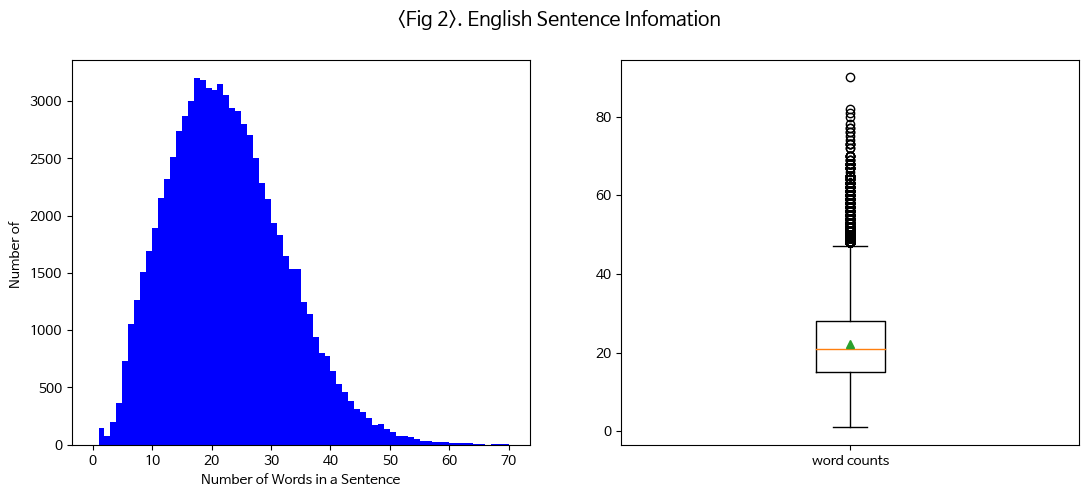

[Sentence Info]
길이 최대:      90
길이 최소:       1
길이 평균:     22.152
길이 표준편차:   9.892

 25/100분위:   15.000
 50/100분위:   21.000
 75/100분위:   28.000
 MAX/100분위:  47.500
 IQR:  13.000


In [26]:
kor_counts = [len(text.split()) for text in dataset["kor"]]
eng_counts = [len(text.split()) for text in dataset["eng"]]

show_sentence_words(kor_counts, "<Fig 1>. Korean Sentence Infomation", [0, 50])
show_sentence_words(eng_counts, "<Fig 2>. English Sentence Infomation", [0, 70])

<br>

## Data Preprocess


#### 단어 수 기준 데이터 필터링

In [27]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df

dataset = filt_sentence_length(dataset, "kor", 33)
dataset = filt_sentence_length(dataset, "eng", 48)

최종적으로 77411 개의 한국어-영어 Paired Senteces 쌍을 사용한다.

In [28]:
len(dataset)

77411

<br>

### 정규식으로 데이터 전처리 + Decoder 입력 데이터에 토큰 추가 전처리


In [29]:
#전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def preprocess_with_token(sentence, decoder_data=False):
    sentence = preprocess_sentence(sentence)

    if decoder_data:   #decoder
        sentence = "<sos> " + sentence + " <eos>"
    return sentence


In [30]:
dataset["kor"] = dataset["kor"].apply(preprocess_sentence)
dataset["eng"] = dataset["eng"].apply(lambda x: preprocess_with_token(x, True))

In [31]:
dataset.sample(30)

,kor,eng
91736,최근 전투를 피해 달아난 콩고 난민들은 잠재적으로 더 무서운 새 적을 만나게 되었습...,<sos> refugees in congo fleeing the latest rou...
12144,믿고싶다 라는 슬로건은 ufo 망상에 잡힌 폭스 멀더역을 맡은 듀코브니가 다나 스컬...,<sos> i want to believe was the slogan on a po...
90241,부시 대통령은 15개월 전 미군 부대의 증원이 시작된 이래로 이라크 내 에서 현저한...,<sos> the president said that since the launch...
86006,국내 최대 포털 사이트 다음커뮤니케이션은 친일 인터넷 커뮤니티 5곳을 폐쇄했다고 밝...,"<sos> the nation s biggest portal , daum commu..."
63159,전 frb 의장을 역임한 뒤 볼커 전 의장은 1996년까지 투자 은행가로서 민간 부...,"<sos> after his tenure there , volcker worked ..."
13477,많은 도시인들이 그런 서비스를 이용하며 자신의 소유 차량을 기꺼이 처분하고 있다 .,<sos> many urbanites have happily ditched thei...
7572,한편 러닝메이트 역할 외 에도 힐러리의 또 다른 역할론도 대두되고 있다 .,"<sos> apart from the vice presidency , analyst..."
58855,일본 고베시 이학연구소 연구진은 쥐의 세포를 영하 20도에서 얼려 16년간 보관했다 .,<sos> researchers at the riken center for deve...
24003,사르코지가 tv인터뷰를 하기 전 행사장에 있던 그는 사르코지 대통령이 우리를 돕기 ...,<sos> i think the french president will do eve...
21328,허세나 아무런 보상도 없이 힐러리경은 1965년 네팔에 자선단체인 히말라야 트러스트...,<sos> without fanfare and without compensation...


### Tokenize the Dataset


https://github.com/keras-team/keras-docs-ko/blob/master/sources/preprocessing/text.md

- tokenize 함수는, Encoder, Decoder Dataset 에 맞게 토큰화를 시키고, 모델의 입력이 될  tensor 와 tokenizer 를 return 한다.

[tf.keras.preprocessing.text.Tokenizer(...) 객체]
- 객체 생성 후,  
- tokenizer.fit_on_texts(corpus_input)메서드로 tokenizer 객체에 corpus_input 주입하여 tokenizer를 학습시키는 과정을 수행한다.
- fit_on_text(text) 일때, text 는 List, Pandas Seires 도 가능
- 단어들을 토큰화하며 각 단어에 고유한 정수 인덱스를 부여합니다. (가장 빈도가 높은 것부터, 낮은 인덱스 부여)  

- 한국어는 형태소 단위로 쪼개진 데이터를 입력으로, 영어는 그냥 원래 Corpus 를 입력으로


In [36]:

def tokenize(corpus, vocab_size, maxlen, encoder_TF=True):
    # Tokenizer 객체 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',            # 토큰화할 때 제거할 문자 지정 (여기서는 없음)
        oov_token="<UNK>",     # Out-Of-Vocabulary (단어 집합에 없는 단어를 나타내는 토큰)
        num_words=vocab_size   # 최대 단어 수 제한
    )

    corpus_input = corpus

    # encoder 데이터일 때, (즉 '한국어') Mecab 으로, 형태소 단위로 쪼개기
    if encoder_TF:
        m = MeCab()
        corpus_input = []
        for sentence in corpus:
            # 문장을 형태소로 분석하여 리스트로 변환하여 저장
            corpus_input.append(m.morphs(sentence))


    # Tokenizer를 훈련 데이터에 맞춰 학습 (위에 설명 참고)
    tokenizer.fit_on_texts(corpus_input)

    # vocab_size를 초과하는 빈도수의 단어들을 삭제
    if vocab_size is not None:
        words_frequency = [w for w, c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]

    # 문장을 정수 시퀀스로 변환하여 저장
    tensor = tokenizer.texts_to_sequences(corpus_input)

    # 정수 시퀀스를 maxlen에 맞게 Padding 처리
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=maxlen
    )

    # 토큰 수 통계 출력
    token_lengths = [len(tokens) for tokens in tensor]
    max_tokens = max(token_lengths)

    print(f"Maximum tokens: {max_tokens}")

    return tensor, tokenizer


In [ ]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], None, None, encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], None, None, encoder_TF=False)

print("Korean Vocab Size:", f"{len(enc_tokenizer.word_index):,}")
print("English Vocab Size:", f"{len(dec_tokenizer.word_index):,}")

Maximum tokens: 77
Maximum tokens: 68
Korean Vocab Size: 51,483
English Vocab Size: 45,584


Vocab Size 와 maxlen 을  좀 더 작게 제한하였다.

In [ ]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], 40000, 50 , encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], 30000, 40 , encoder_TF=False)


Maximum tokens: 50
Maximum tokens: 40


<br>

## 모델 설계 및 학습


#### 모델 설계


In [37]:
#Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)

    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


#인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            enc_units,
            dropout=0.2,
            return_sequences=True
        )

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out


#디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            dec_units,
            dropout=0.2,
            return_sequences=True,
            return_state=True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn



SRC_VOCAB_SIZE = len(enc_tokenizer.word_index) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.word_index) + 1

units = 256
embedding_dim = 256



In [ ]:
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

<br>

#### 학습 하이퍼파리미터 설정



In [ ]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)



<br>

#### 모델 학습 함수 설정

In [ ]:

#손실 함수
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)



#학습 함수
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<sos>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss




#### 모델 학습

In [ ]:

EPOCHS = 10
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1210/1210 [02:44<00:00,  7.37it/s, Loss 2.8751]


<br>

## 모델 평가


- 학습된 모델에 한국어 문장을 입력하여 모델이 출력한 번역 결과를 확인
- 변역 문장과 함께 Attention Matrix를 시각화하여 문장이 올바르게 학습 되었는지 확인


#### 모델 평가를 위한 함수 생성


In [ ]:
# 번역
def evaluate(sentence, encoder, decoder):
    m = MeCab()

    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))

    sentence = preprocess_sentence(sentence)
    sentence = m.morphs(sentence)

    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs,
        maxlen=enc_tensor.shape[-1],
        padding='post'
    )

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<sos>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention



#Matrix 생성 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


#번역 및 시각화 함수
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))
    return(result)


<br>

#### 모델 평가


Input: ['아버지', '가', '방', '에', '들어가', '신다', '.']
Predicted translation: the man , who was the <UNK> . <eos> 


<ipython-input-30-5b4d66de864f>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-5b4d66de864f>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


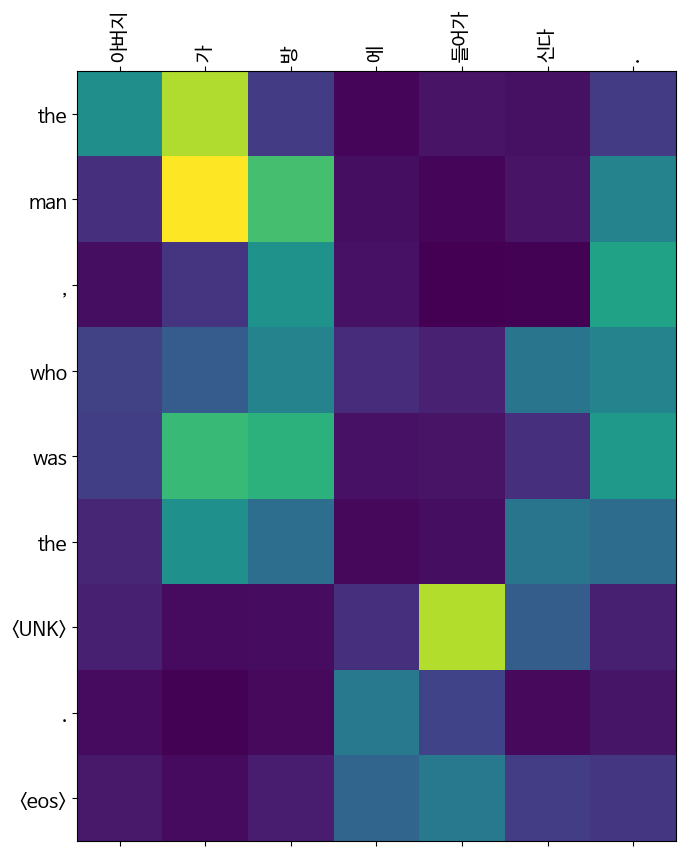


Input: ['저', '는', '지금', '공부', '를', '하', '고', '있', '어요', '.']
Predicted translation: i m sure i am proud of the time . <eos> 


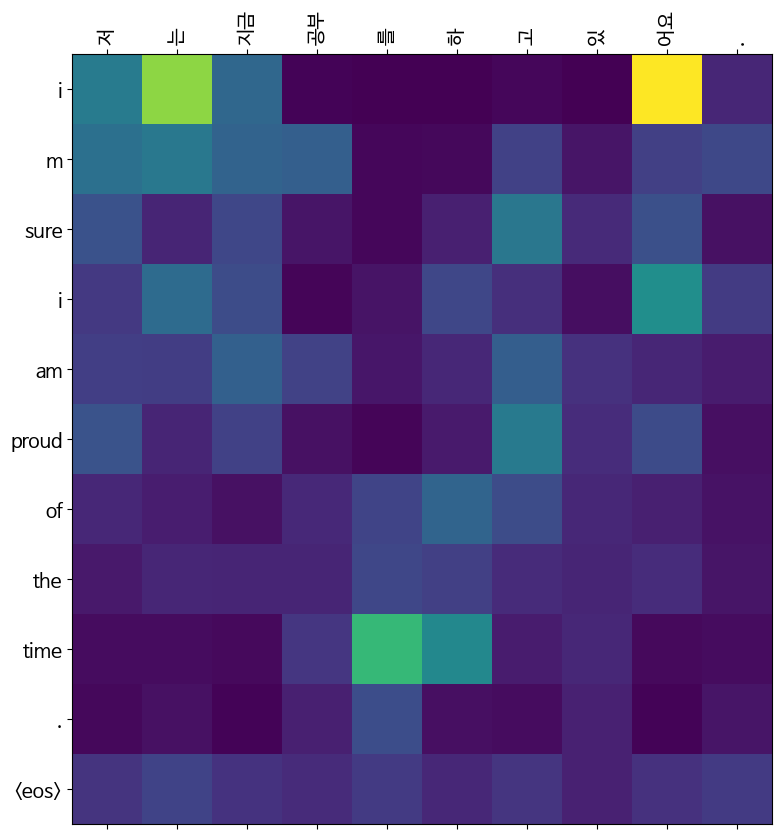


Input: ['비', '가', '올', '수', '있', '으니', '꼭', '우산', '을', '챙기', '세요', '.']
Predicted translation: the <UNK> is a few days . <eos> 


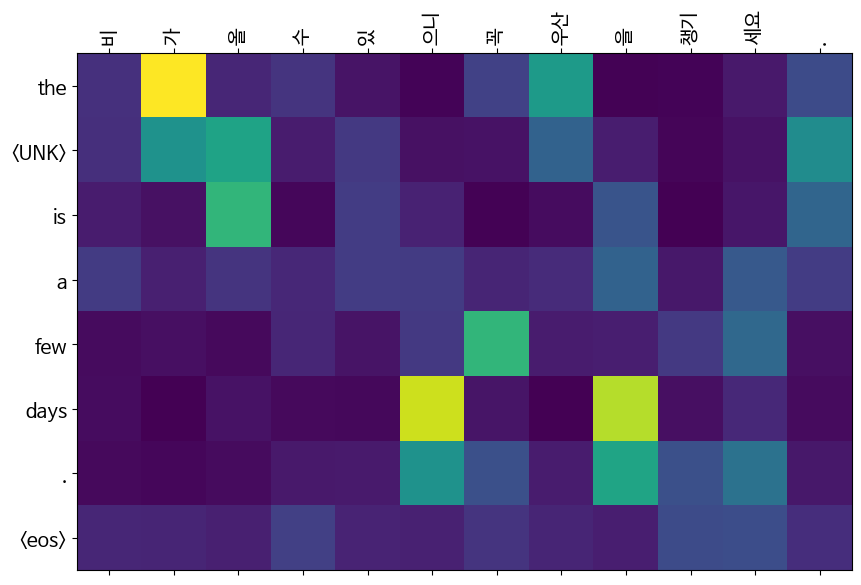


Input: ['컴퓨터', '가', '고장났', '어요', '.']
Predicted translation: i don t know how to be a <UNK> . <eos> 


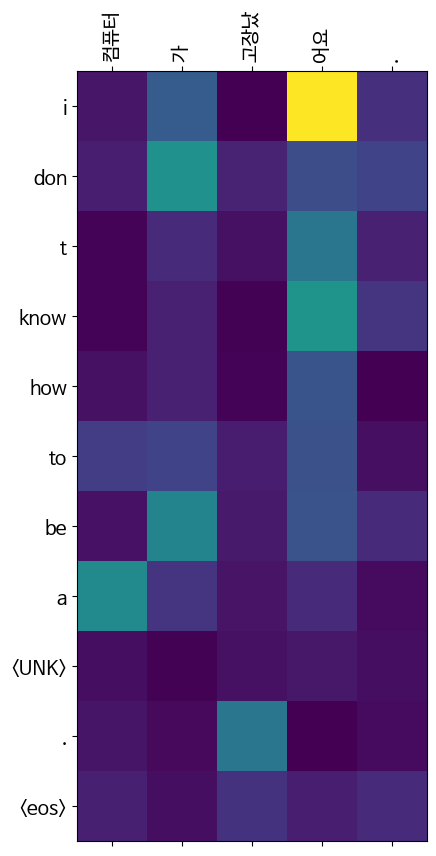


Input: ['저희', '내일', '저녁', '7', '시', '에', '만날', '래요', '?']
Predicted translation: we re going to the white house ? <eos> 


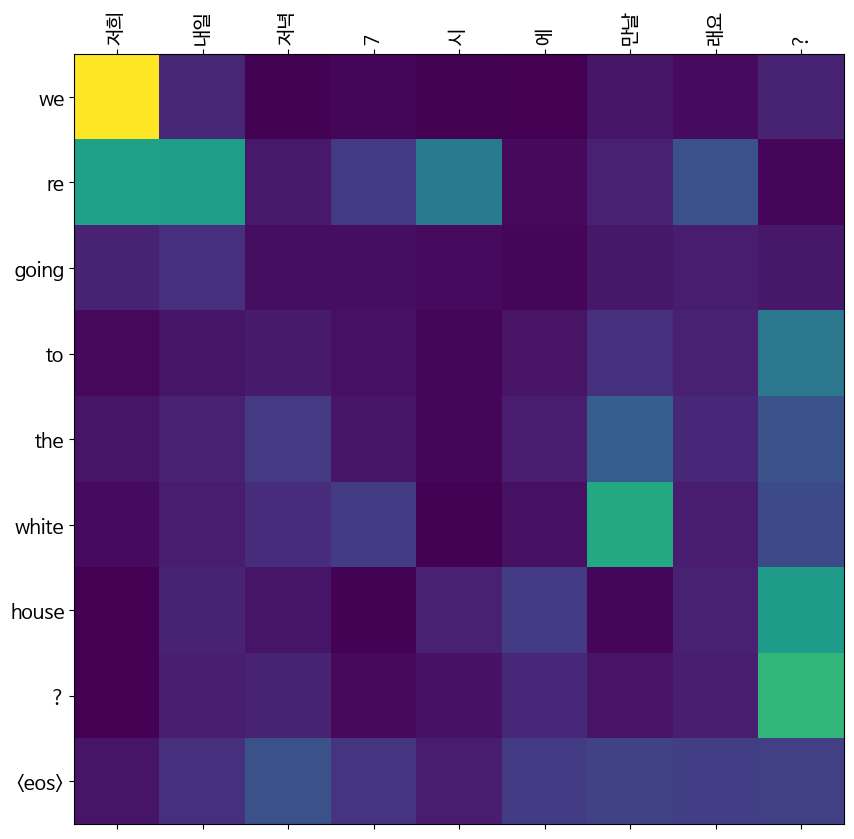


Input: ['현재', '날씨', '는', '28', '도', '입니다', '.']
Predicted translation: the weather is the first time . <eos> 


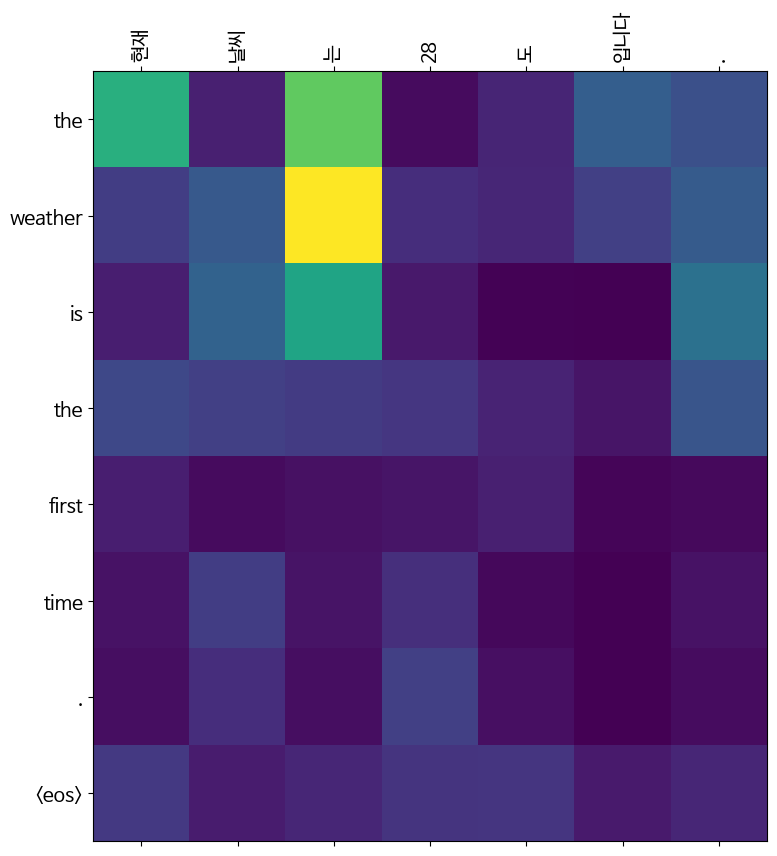


Input: ['당신', '을', '정말', '사랑', '해요', '.']
Predicted translation: you know you know you re going to be a lot of the right direction . <eos> 


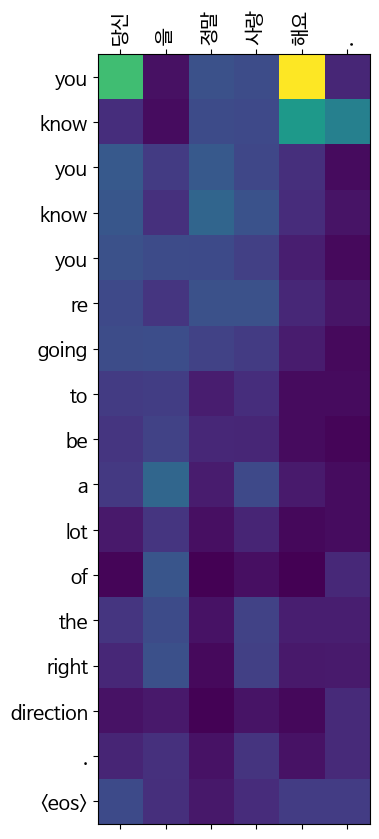


Input: ['저', '는', '음악', '을', '들으면서', '산책', '하', '는', '것', '을', '좋', '아', '해요', '.']
Predicted translation: i don t want to be a good time , he said . <eos> 


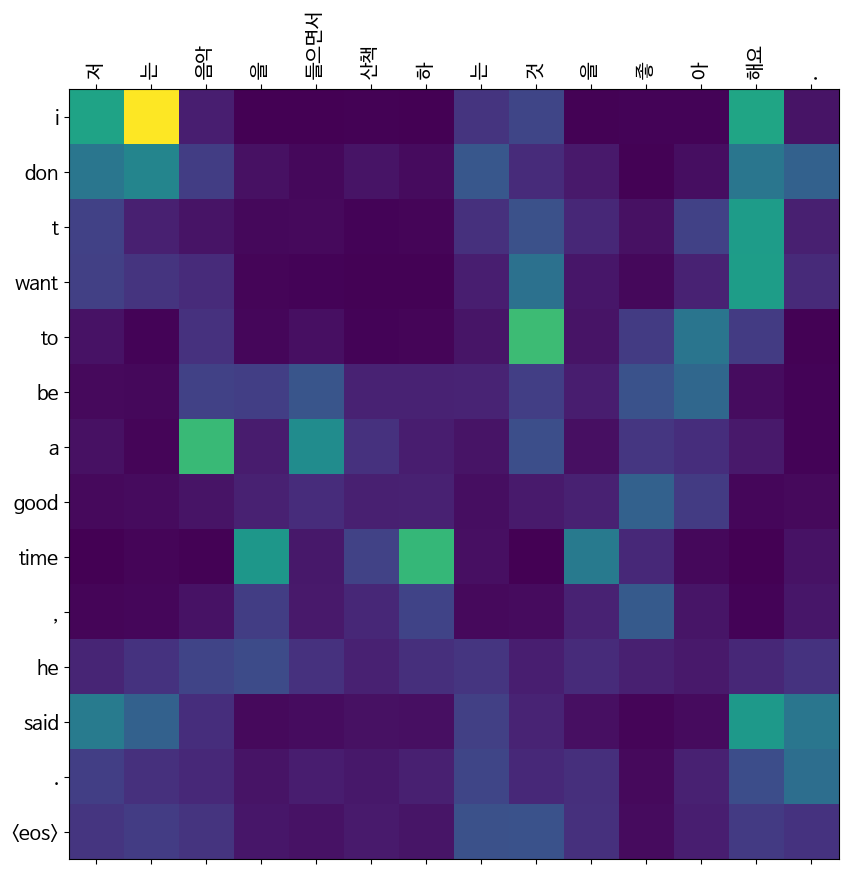


Input: ['최근', '에', '재밌', '게', '본', '영화', '가', '있', '나요', '?']
Predicted translation: the film is a lot of the most important ? <eos> 


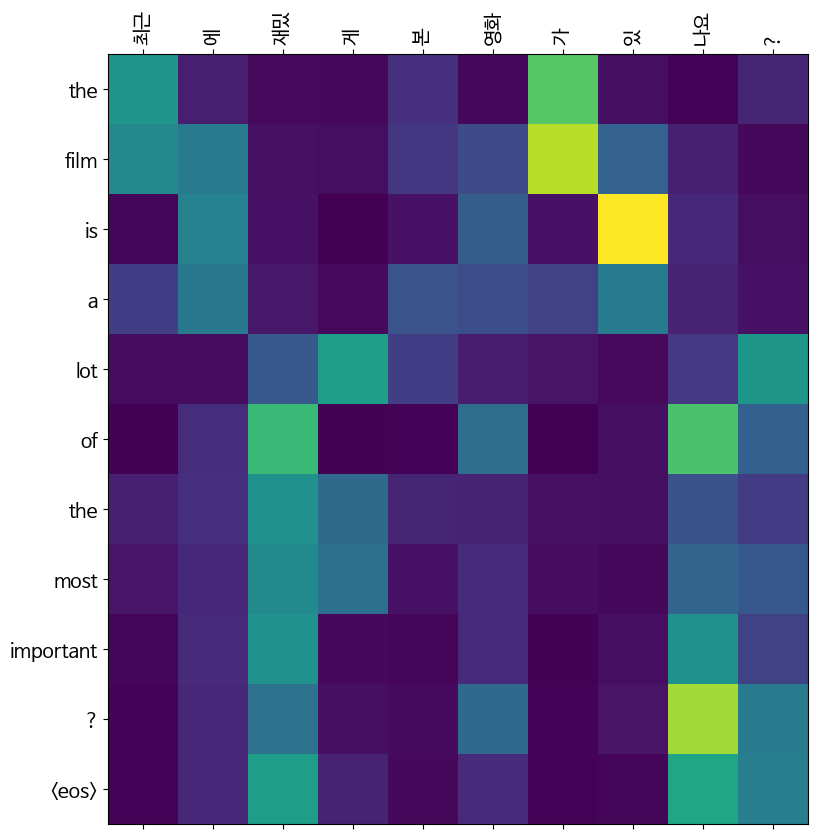


Input: ['여행', '가', '고', '싶', '어요', '.']
Predicted translation: i don t know how i don t know how i don t know how i don t know how i don t know how i don t know how i don t know how i don t know how 


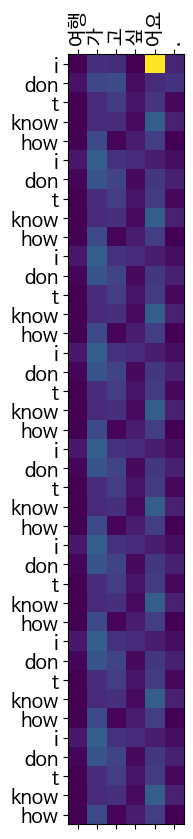

In [ ]:
sentences = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]

for sentence in sentences:
    translate(sentence, encoder, decoder)
    print()

In [ ]:
# 번역 결과와 원래 문장을 저장할 리스트
translations = []
original_sentences = []

# 주어진 문장들 순회하며 번역 및 결과 저장
for sentence in sentences:
    result, _, _ = evaluate(sentence, encoder, decoder)
    translations.append(result)
    original_sentences.append(sentence)

# 데이터 프레임 생성
df = pd.DataFrame({
    'Original Sentence': original_sentences,
    'Translation': translations
})

# 데이터 프레임 출력
display(df)

,Original Sentence,Translation
0,아버지가 방에 들어가신다.,"the man , who was the <UNK> . <eos>"
1,저는 지금 공부를 하고 있어요.,i m sure i am proud of the time . <eos>
2,비가 올 수 있으니 꼭 우산을 챙기세요.,the <UNK> is a few days . <eos>
3,컴퓨터가 고장났어요.,i don t know how to be a <UNK> . <eos>
4,저희 내일 저녁 7시에 만날래요?,we re going to the white house ? <eos>
5,현재 날씨는 28도 입니다.,the weather is the first time . <eos>
6,당신을 정말 사랑해요.,you know you know you re going to be a lot of ...
7,저는 음악을 들으면서 산책하는 것을 좋아해요.,"i don t want to be a good time , he said . <eos>"
8,최근에 재밌게 본 영화가 있나요?,the film is a lot of the most important ? <eos>
9,여행 가고 싶어요.,i don t know how i don t know how i don t know...


# Trial + 10 epoch

In [ ]:

EPOCHS = 10
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1210/1210 [02:43<00:00,  7.41it/s, Loss 1.8378]


<br>

## 모델 평가


- 학습된 모델에 한국어 문장을 입력하여 모델이 출력한 번역 결과를 확인
- 변역 문장과 함께 Attention Matrix를 시각화하여 문장이 올바르게 학습 되었는지 확인


<br>

#### 모델 평가


<ipython-input-30-5b4d66de864f>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-5b4d66de864f>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['아버지', '가', '방', '에', '들어가', '신다', '.']
Predicted translation: it s a knife . <eos> 


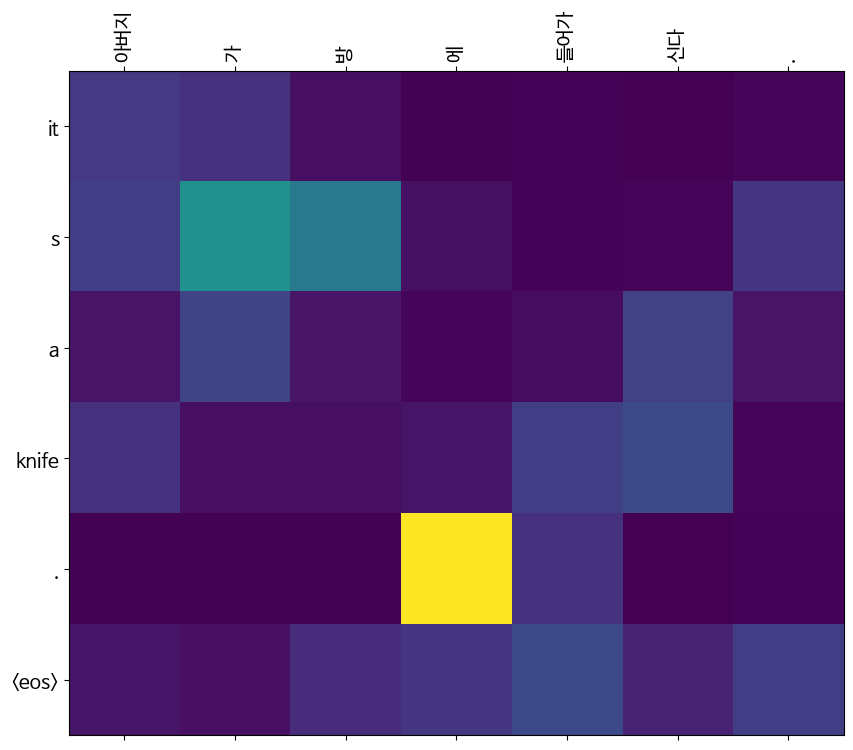


Input: ['저', '는', '지금', '공부', '를', '하', '고', '있', '어요', '.']
Predicted translation: i m sure that we re doing , we re doing , we re doing , we re doing , we re doing , we re doing , we re doing , we re doing , we re doing , 


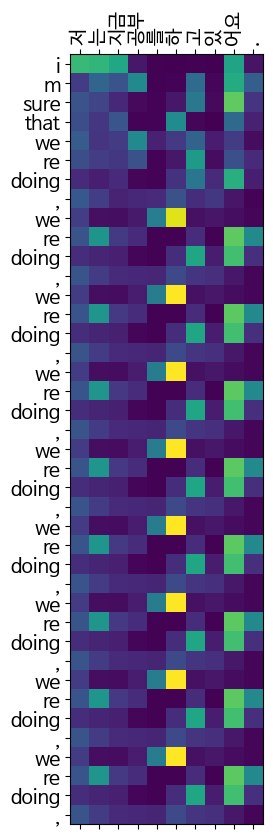


Input: ['비', '가', '올', '수', '있', '으니', '꼭', '우산', '을', '챙기', '세요', '.']
Predicted translation: you can t be a day . <eos> 


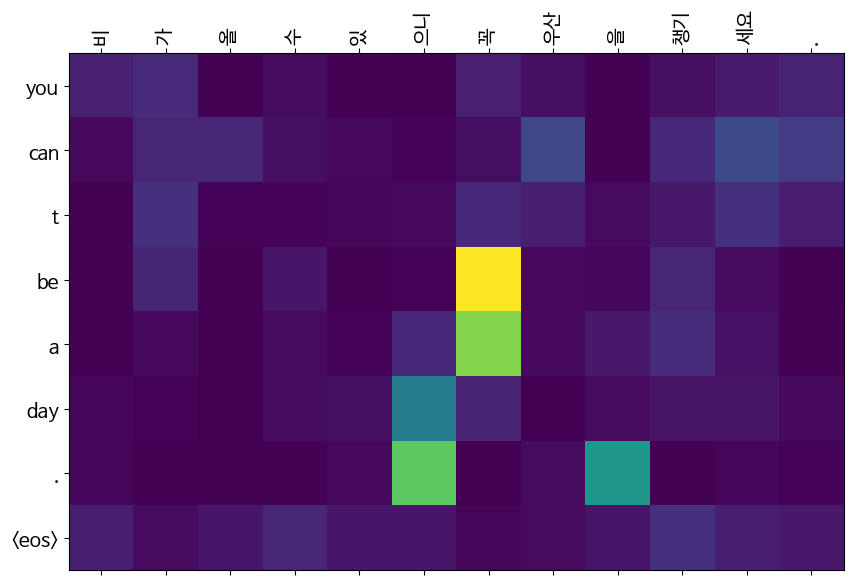


Input: ['컴퓨터', '가', '고장났', '어요', '.']
Predicted translation: the computer players will be a little a day . <eos> 


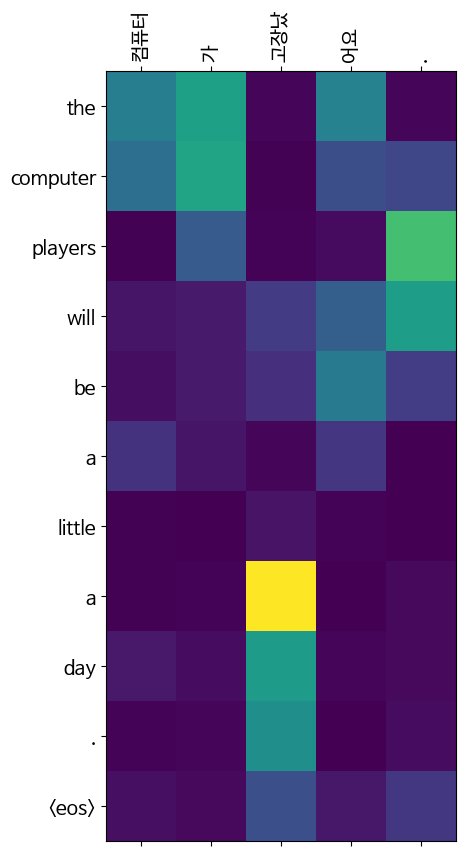


Input: ['저희', '내일', '저녁', '7', '시', '에', '만날', '래요', '?']
Predicted translation: why we re not the defeat <eos> 


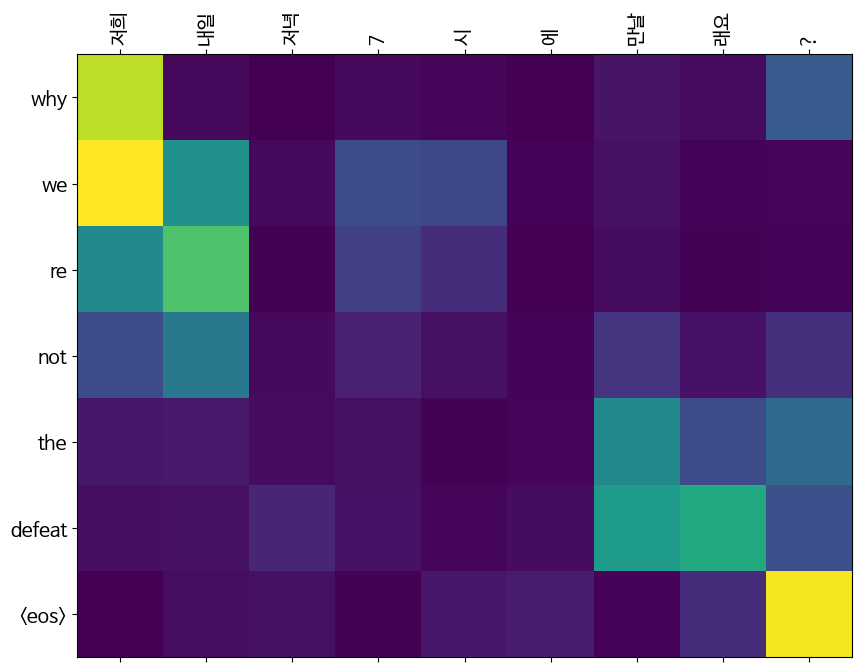


Input: ['현재', '날씨', '는', '28', '도', '입니다', '.']
Predicted translation: the weather is now . <eos> 


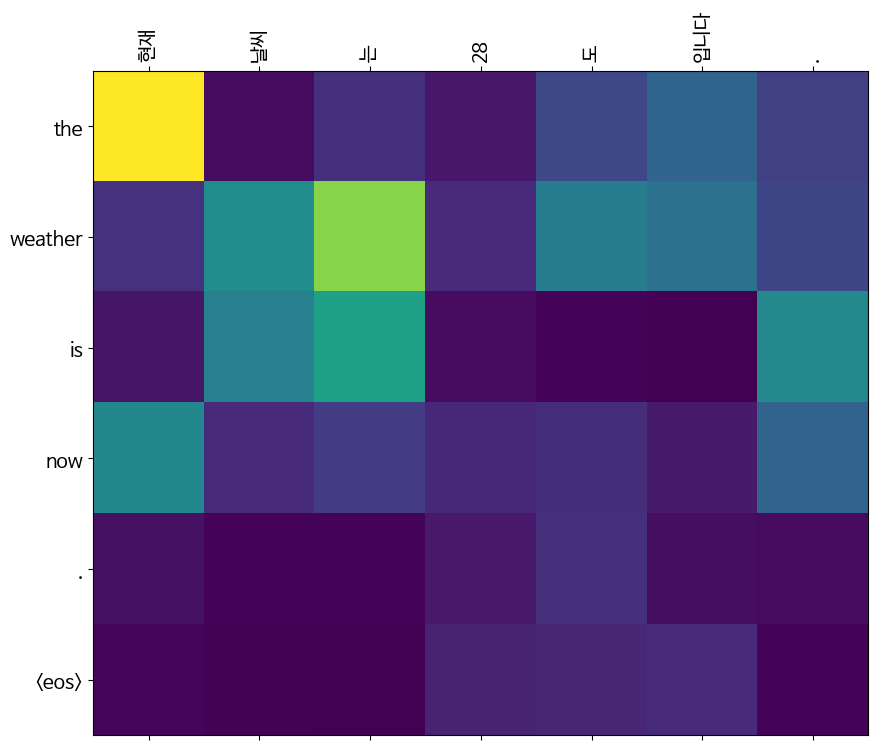


Input: ['당신', '을', '정말', '사랑', '해요', '.']
Predicted translation: you know , you know you re in the <UNK> . <eos> 


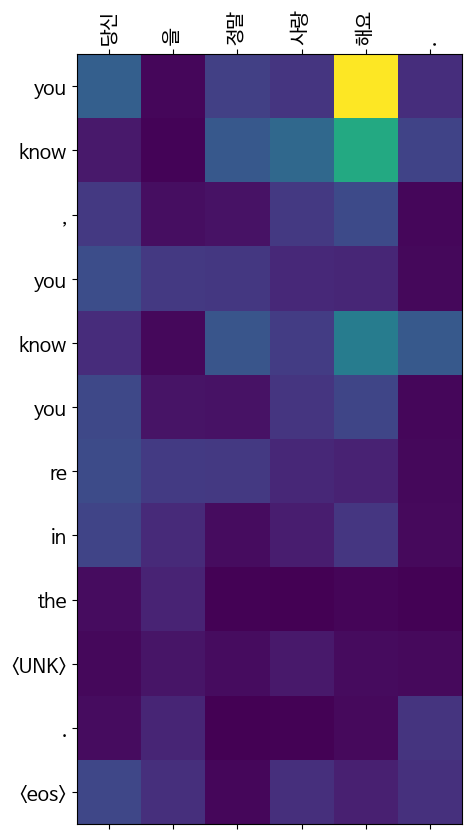


Input: ['저', '는', '음악', '을', '들으면서', '산책', '하', '는', '것', '을', '좋', '아', '해요', '.']
Predicted translation: i m happy to be a good <UNK> . <eos> 


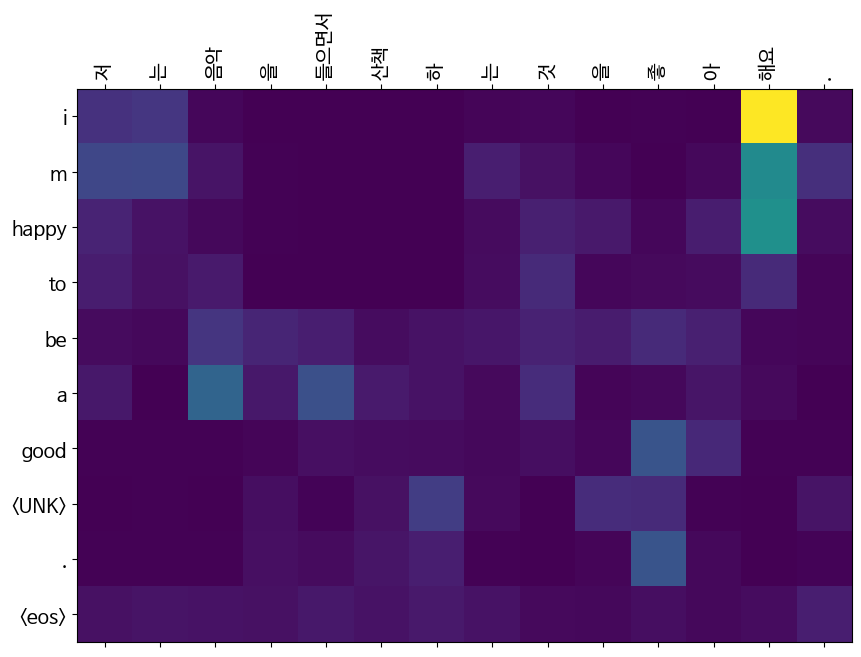


Input: ['최근', '에', '재밌', '게', '본', '영화', '가', '있', '나요', '?']
Predicted translation: how the pros ? <eos> 


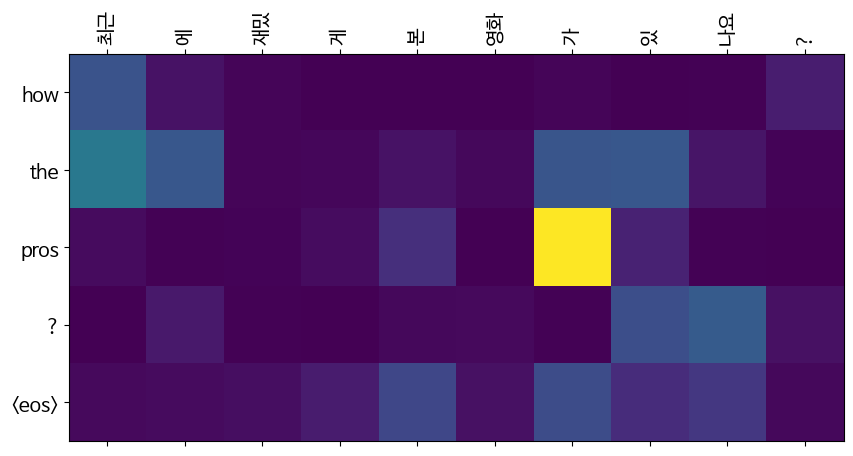


Input: ['여행', '가', '고', '싶', '어요', '.']
Predicted translation: i m not going to go <eos> 


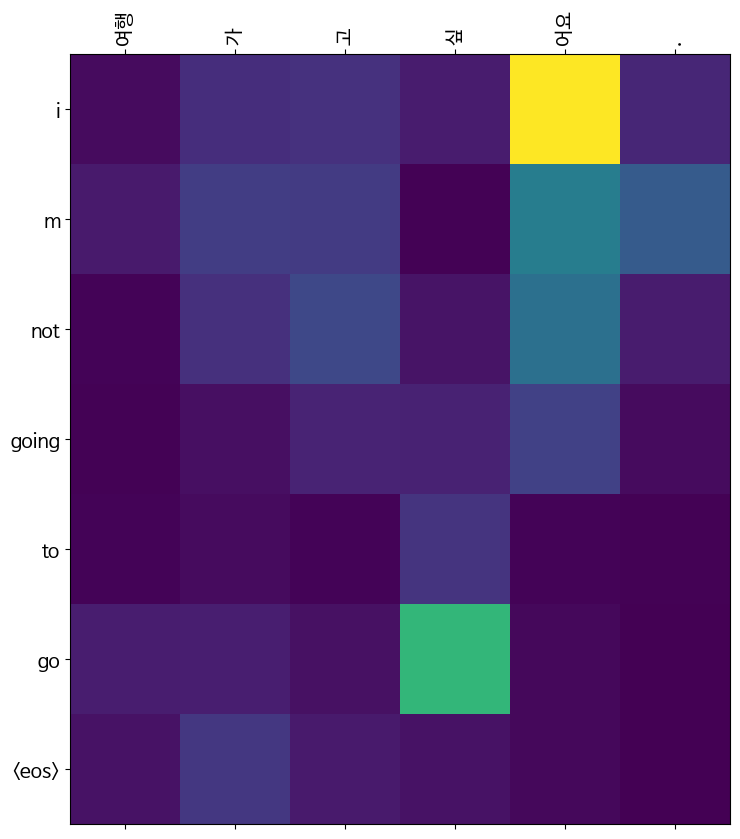

In [ ]:
sentences = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]

for sentence in sentences:
    translate(sentence, encoder, decoder)
    print()

In [ ]:
# 번역 결과와 원래 문장을 저장할 리스트
translations = []
original_sentences = []

# 주어진 문장들 순회하며 번역 및 결과 저장
for sentence in sentences:
    result, _, _ = evaluate(sentence, encoder, decoder)
    translations.append(result)
    original_sentences.append(sentence)

# 데이터 프레임 생성
df = pd.DataFrame({
    'Original Sentence': original_sentences,
    'Translation': translations
})

# 데이터 프레임 출력
display(df)

,Original Sentence,Translation
0,아버지가 방에 들어가신다.,it s a knife . <eos>
1,저는 지금 공부를 하고 있어요.,"i m sure that we re doing , we re doing , we r..."
2,비가 올 수 있으니 꼭 우산을 챙기세요.,you can t be a day . <eos>
3,컴퓨터가 고장났어요.,the computer players will be a little a day . ...
4,저희 내일 저녁 7시에 만날래요?,why we re not the defeat <eos>
5,현재 날씨는 28도 입니다.,the weather is now . <eos>
6,당신을 정말 사랑해요.,"you know , you know you re in the <UNK> . <eos>"
7,저는 음악을 들으면서 산책하는 것을 좋아해요.,i m happy to be a good <UNK> . <eos>
8,최근에 재밌게 본 영화가 있나요?,how the pros ? <eos>
9,여행 가고 싶어요.,i m not going to go <eos>
